In [1]:
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from figure8_env import MyEnv as figure8_env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

In [14]:
figure8_give_rewards = True #False
nn_yaml = 'network_noconv.yaml'
higher_dim_obs = True #False

In [ ]:
class Defaults:
    # ----------------------
    # Experiment Parameters
    # ----------------------
    steps_per_epoch = 5000
    epochs = 50
    steps_per_test = 1000
    period_btw_summary_perfs = 1
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    frame_skip = 2

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    update_rule = 'rmsprop'
    learning_rate = 5 * 1E-4 # 1E-4
    learning_rate_decay = 0.9
    discount = 0.9
    discount_inc = 1
    discount_max = 0.99
    rms_decay = 0.9
    rms_epsilon = 0.0001
    momentum = 0
    clip_norm = 1.0
    epsilon_start = 1.0
    epsilon_min = 1.0
    epsilon_decay = 10000
    update_frequency = 1
    replay_memory_size = 1000000 #replacing with 200000 will works just fine (in case you dont have 18gb of memory)
    batch_size = 32
    freeze_interval = 1000
    deterministic = False

In [17]:
parameters = Defaults()
if parameters.deterministic:
    rng = np.random.RandomState(123456)
else:
    rng = np.random.RandomState()

# --- Instantiate environment ---
env = figure8_env(
    give_rewards=figure8_give_rewards,
    higher_dim_obs=higher_dim_obs,
    )

# --- Instantiate learning_algo ---
learning_algo = CRAR(
    env,
    parameters.rms_decay,
    parameters.rms_epsilon,
    parameters.momentum,
    parameters.clip_norm,
    parameters.freeze_interval,
    parameters.batch_size,
    parameters.update_rule,
    rng,
    high_int_dim=False,
    internal_dim=2, lr=parameters.learning_rate,
    nn_yaml=nn_yaml
    )

if figure8_give_rewards:
    train_policy = None
    test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)
else:
    train_policy = FixedFigure8Policy.FixedFigure8Policy(learning_algo, env.nActions(), rng)
    test_policy = FixedFigure8Policy.FixedFigure8Policy(learning_algo, env.nActions(), rng)

# --- Instantiate agent ---
agent = NeuralAgent(
    env,
    learning_algo,
    parameters.replay_memory_size,
    1,
    parameters.batch_size,
    rng,
    train_policy=train_policy,
    test_policy=test_policy)

# --- Create unique filename for FindBestController ---
h = hash(vars(parameters), hash_name="sha1")
fname = "test_" + h
print("The parameters hash is: {}".format(h))
print("The parameters are: {}".format(parameters))

# As for the discount factor and the learning rate, one can update periodically the parameter of the epsilon-greedy
# policy implemented by the agent. This controllers has a bit more capabilities, as it allows one to choose more
# precisely when to update epsilon: after every X action, episode or epoch. This parameter can also be reset every
# episode or epoch (or never, hence the resetEvery='none').
agent.attach(bc.EpsilonController(
    initial_e=parameters.epsilon_start,
    e_decays=parameters.epsilon_decay,
    e_min=parameters.epsilon_min,
    evaluate_on='action',
    periodicity=1,
    reset_every='none'))

agent.run(10, 500)
print("end gathering data")

# --- Bind controllers to the agent ---
# Before every training epoch (periodicity=1), we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController(
    evaluate_on='epoch', 
    periodicity=1))

# Every epoch end, one has the possibility to modify the learning rate using a LearningRateController. Here we 
# wish to update the learning rate after every training epoch (periodicity=1), according to the parameters given.
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters.learning_rate, 
    learning_rate_decay=parameters.learning_rate_decay,
    periodicity=1))

# Same for the discount factor.
agent.attach(bc.DiscountFactorController(
    initial_discount_factor=parameters.discount, 
    discount_factor_growth=parameters.discount_inc, 
    discount_factor_max=parameters.discount_max,
    periodicity=1))

# During training epochs, we want to train the agent after every [parameters.update_frequency] action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode, hence the two last arguments.
agent.attach(bc.TrainerController(
    evaluate_on='action', 
    periodicity=parameters.update_frequency, 
    show_episode_avg_V_value=True, 
    show_avg_Bellman_residual=True))

# We wish to discover, among all versions of our neural network (i.e., after every training epoch), which one 
# has the highest validation score.
# To achieve this goal, one can use the FindBestController along with an InterleavedTestEpochControllers. It is 
# important that the validationID is the same than the id argument of the InterleavedTestEpochController.
# The FindBestController will dump on disk the validation scores for each and every network, as well as the 
# structure of the neural network having the best validation score. These dumps can then used to plot the evolution 
# of the validation and test scores (see below) or simply recover the resulting neural network for your 
# application.
agent.attach(bc.FindBestController(
    validationID=figure8_env.VALIDATION_MODE,
    testID=None,
    unique_fname=fname))

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "validation epoch" between each training epoch. For each validation epoch, we want also to display the sum of all 
# rewards obtained, hence the showScore=True. Finally, we want to call the summarizePerformance method of ALE_env 
# every [parameters.period_btw_summary_perfs] *validation* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=figure8_env.VALIDATION_MODE, 
    epoch_length=parameters.steps_per_test,
    periodicity=1,
    show_score=True,
    summarize_every=1))

The parameters hash is: 62977be8e45d8a56a5537c11dfd5d2fd8dda69e0
The parameters are: <__main__.Defaults object at 0x2b64dc33d2b0>
end gathering data


In [5]:
try:
    os.mkdir("params")
except Exception:
    pass
dump(vars(parameters), "params/" + fname + ".jldump")
agent.gathering_data=False
agent.run(parameters.epochs, parameters.steps_per_epoch)

# --- Show results ---
basename = "scores/" + fname
scores = load(basename + "_scores.jldump")
print (scores)

ValueError: setting an array element with a sequence.

In [ ]:
agent._learning_algo.crar.encoder

# Visualize performance

In [18]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

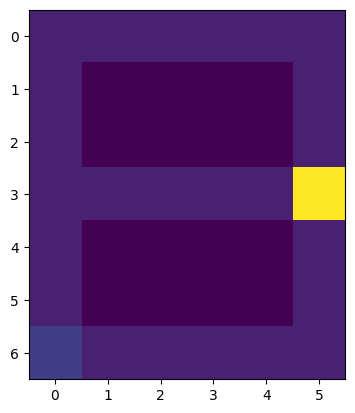

/share/ctn/users/cf2794/Code/deer/deer/learning_algos/CRAR_torch.py:395: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  state = torch.as_tensor(state, device=self.device).float()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (7x6 and 1x200)

In [19]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    plt.figure()
    plt.imshow(np.flip(obs[0].squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward = agent._step()
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break

In [ ]:
action

In [ ]:
obs[0]

In [ ]:
np.argwhere(obs[0]==10)

In [ ]:
obs